In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [17]:
def preprocess(data):
    '''this function responsible on removing unrelveant features from data and split it '''
        df=data.copy()
        df.drop(columns=['index','person','event','value','became_member_on'],inplace=True)
        df=pd.get_dummies(data=df,columns=['type','gender']).drop(columns=['type_discount','gender_O'])
        df=df.drop(columns='success').assign(success=df['success'].values)
        col=df.columns
        
        X_train, X_test, y_train, y_test= train_test_split(df.iloc[:,:-1].values, df.iloc[:,-1].values,
                                    test_size=0.25, random_state=10,stratify= df.iloc[:,-1].values)
        return X_train, X_test, y_train, y_test ,col

In [53]:
def model_learning(clf,X_train, X_test, y_train, y_test,f1=False,scaler=False):
    '''to fit the model on training data and calculate accuracy and f1 for training and testing
    input:
    clf : ML model
    f1 : to print f1 score 
    scaler : to perform standerdscaler (for logistic and svm)  
    output:
    dic with all parameters might nedded
    
    '''
    if scaler:
        Scaler = StandardScaler()
        X_train=Scaler.fit_transform(X_train)
        X_test=Scaler.transform(X_test)
    
    clf.fit(X_train,y_train)

    y_train_pred=clf.predict(X_train)   
    print('train_acc',round(accuracy_score(y_train, y_train_pred)*100,3))


    if f1:
        print('precision {0[0]:.3f}\nrecall {0[1]:.3f}\nf1 {0[2]:.3f}\n'.format(precision_recall_fscore_support(y_train,
                                                                                            y_train_pred, average='weighted')))

    y_test_pred=clf.predict(X_test)
    print('test_acc',round(accuracy_score(y_test, y_test_pred)*100,3))


    if f1:
         print('precision {0[0]:.3f}\nrecall {0[1]:.3f}\nf1 {0[2]:.3f}\n'.format(precision_recall_fscore_support(y_test,
                                                                                         y_test_pred, average='weighted')))
    
    
    if scaler:
        X_train=Scaler.inverse_transform(X_train)
        X_test=Scaler.inverse_transform(X_test)
        parameters={'X_train':X_train,'X_test':X_test
                ,'y_train':y_train,'y_test':y_test,
               'y_train_pred':y_train_pred,'y_test_pred':y_test_pred,'model':clf,'scaler':Scaler}
    else:
        parameters={'X_train':X_train,'X_test':X_test
                ,'y_train':y_train,'y_test':y_test,
               'y_train_pred':y_train_pred,'y_test_pred':y_test_pred,'model':clf}
    
    return parameters
    
    

In [22]:
#logistic regression with L1 regulariztion will be a baseline through the process of feature engineering
#each time we call this function will display the acuccray on training and testing data 
#as well as the feartures with cofficient equal zero


def baseline_model(data,features_coffecients=False,scaler=True,f1=False):
    
    X_train, X_test, y_train, y_test,col = preprocess(data)


    
    clf = LogisticRegression(random_state=0,penalty='l1',max_iter=100,solver='liblinear',C=.7)
    
    
    parameters= model_learning(clf,X_train, X_test, y_train, y_test,f1,scaler)
    parameters['columns']=col
    
    important_features = pd.Series(data=np.transpose(parameters['model'].coef_).reshape(-1,),index=parameters['columns'][:-1])
    important_features=important_features.abs().sort_values(ascending=False)
    if features_coffecients:
        
        return important_features,parameters
    else:
        print('features with zero coff\n',important_features[important_features==0].index.to_list())
        return parameters
    

In [14]:

from xgboost import XGBClassifier

def xgb_func(data,f1=False,colsample_bylevel= 0.7,colsample_bytree= 0.75,gamma= 0.01,
                 learning_rate= 0.1,max_depth= 8,min_child_weight= 0.1,n_estimators= 50,reg_lambda= 10.0,
             subsample= 1.0,scaler=False,features=False):
    
    
    X_train, X_test, y_train, y_test ,col= preprocess(data)
    
    clf = XGBClassifier('binary:logistic',colsample_bylevel= 0.7,colsample_bytree= 0.75,gamma= 0.01,
                 learning_rate= 0.1,max_depth= 8,min_child_weight= 0.1,n_estimators= 50,reg_lambda= 10.0,subsample= 1.0)
    
    parameters= model_learning(clf,X_train, X_test, y_train, y_test,f1,scaler)
    parameters['columns']=col    
    
    #compute features impoertance
    if features:
        important_features = pd.Series(data=parameters['model'].feature_importances_,index=parameters['columns'][:-1])
        important_features.sort_values(ascending=False,inplace=True)
        return important_features,parameters
    
    else:
        return parameters
    
    

In [13]:

from sklearn.ensemble import GradientBoostingClassifier

def gradient(data,features=False,max_depth=3,n_estimators=20,max_features=.75,min_impurity_decrease=0.0,f1=False,
             init=None,learning_rate=0.1,scaler=False):
    
    X_train, X_test, y_train, y_test ,col= preprocess(data)

    
    clf = GradientBoostingClassifier(max_depth=max_depth, random_state=0,n_estimators=n_estimators
                                 ,max_features=max_features,min_impurity_decrease=min_impurity_decrease
                                ,init=init,learning_rate=learning_rate)

    parameters= model_learning(clf,X_train, X_test, y_train, y_test,f1,scaler)
    parameters['columns']=col    
    
    if features:
        important_features = pd.Series(data=parameters['model'].feature_importances_,index=parameters['columns'][:-1])
        important_features.sort_values(ascending=False,inplace=True)
        return important_features,parameters
    else:
        return parameters
    

In [11]:

from sklearn.ensemble import RandomForestClassifier

def random_forest(data,features=False,max_depth=8,n_estimators=100,max_features=.75,
                  min_impurity_decrease=0.0,f1=False,scaler=False):
    
    X_train, X_test, y_train, y_test,col = preprocess(data)
    
    clf = RandomForestClassifier(max_depth=max_depth, random_state=0,n_estimators=n_estimators
                                 ,max_features=max_features,min_impurity_decrease=min_impurity_decrease)
    
    parameters= model_learning(clf,X_train, X_test, y_train, y_test,f1,scaler)
    parameters['columns']=col    
    
    if features:
        important_features = pd.Series(data=parameters['model'].feature_importances_,index=parameters['columns'][:-1])
        important_features.sort_values(ascending=False,inplace=True)
        return important_features,parameters
    else:
        return parameters
    

In [10]:
from sklearn.svm import SVC

def svm(data,max_iter=500,kernel='poly',degree=1,tol=0.1,C=0.8,f1=False,scaler=True):
    
    X_train, X_test, y_train, y_test,col = preprocess(data)

    clf=SVC(max_iter=max_iter,kernel=kernel,degree=degree,tol=tol,C=C)
    
  
    parameters=model_learning(clf,X_train, X_test, y_train, y_test,f1,scaler)
    parameters['columns']=col    
    return parameters


    

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_test_df=pd.read_csv('data.csv',parse_dates=['became_member_on'])

train_test_df['month']=train_test_df.became_member_on.dt.month
train_test_df['year']=train_test_df.became_member_on.dt.year


# Features Engineer

In [4]:
#grap all features relates to first time of events for each offer
first_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+received$')].to_list()
first_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+viewed$')].to_list()
first_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+completed$')].to_list()

#grap all features relates to first time of events for each offer
last_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+received$')].to_list()
last_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+viewed$')].to_list()
last_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+completed$')].to_list()

#grap all features relates to number of events for each offer
count_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+received$')].to_list()
count_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+viewed$')].to_list()
count_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+completed$')].to_list()

In [5]:
train_test_df.head()

,index,person,event,time,type,value,reward,difficulty,duration,success,first_bogo_received,first_discount_received,first_informational_received,first_bogo_viewed,first_discount_viewed,first_informational_viewed,first_bogo_completed,first_discount_completed,last_bogo_received,last_discount_received,last_informational_received,last_bogo_viewed,last_discount_viewed,last_informational_viewed,last_bogo_completed,last_discount_completed,count_bogo_received,count_discount_received,count_informational_received,count_bogo_viewed,count_discount_viewed,count_informational_viewed,count_bogo_completed,count_discount_completed,max_duration_bogo,max_duration_discount,max_duration_informational,min_duration_bogo,min_duration_discount,min_duration_informational,mean_duration_bogo,mean_duration_discount,mean_duration_informational,median_duration_bogo,median_duration_discount,median_duration_informational,sum_duration_bogo,sum_duration_discount,sum_duration_informational,max_reward_bogo,max_reward_discount,min_reward_bogo,min_reward_discount,mean_reward_bogo,mean_reward_discount,median_reward_bogo,median_reward_discount,sum_reward_bogo,sum_reward_discount,max_difficulty_bogo,max_difficulty_discount,min_difficulty_bogo,min_difficulty_discount,mean_difficulty_bogo,mean_difficulty_discount,median_difficulty_bogo,median_difficulty_discount,sum_difficulty_bogo,sum_difficulty_discount,time_first_transaction,time_last_transaction,count_transaction,min_transaction,max_transaction,mean_transaction,median_transaction,sum_transaction,last_transaction,count_informational_completed,gender,age,became_member_on,income,first_informational_completed,last_informational_completed,month,year
0,0.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,0.0,informational,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0,O,40.0,2018-01-09,57000.0,-1.0,-1.0,1,2018
1,53176.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,168.0,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,6.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,132.0,1.0,13.49,13.49,13.49,13.49,13.49,13.49,0,O,40.0,2018-01-09,57000.0,-1.0,-1.0,1,2018
2,110829.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,336.0,informational,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,0.0,-1.0,168.0,0.0,-1.0,186.0,6.0,-1.0,252.0,-1.0,168.0,0.0,-1.0,186.0,6.0,-1.0,252.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,4.0,0.0,7.0,4.0,0.0,7.0,4.0,0.0,7.0,4.0,0.0,7.0,4.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,132.0,252.0,2.0,11.93,13.49,12.71,12.71,25.42,11.93,0,O,40.0,2018-01-09,57000.0,-1.0,-1.0,1,2018
3,150597.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,408.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,-1.0,168.0,0.0,-1.0,186.0,6.0,-1.0,252.0,-1.0,168.0,336.0,-1.0,186.0,354.0,-1.0,252.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,7.0,4.0,0.0,7.0,3.0,0.0,7.0,3.5,0.0,7.0,3.5,0.0,7.0,7.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,132.0,252.0,2.0,11.93,13.49,12.71,12.71,25.42,11.93,0,O,40.0,2018-01-09,57000.0,-1.0,-1.0,1,2018
4,201571.0,0011e0d4e6b944f998e987f904e8c1e5,offer received,504.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,1.0,-1.0,168.0,0.0,-1.0,186.0,6.0,-1.0,252.0,-1.0,408.0,336.0,-1.0,432.0,354.0,-1.0,252.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,10.0,4.0,0.0,7.0,3.0,0.0,8.5,3.5,0.0,8.5,3.5,0.0,17.0,7.0,0.0,5.0,0.0,3.0,0.0,4.0,0.0,4.0,0.0,8.0,0.0,20.0,0.0,7.0,0.0,13.5,0.0,13.5,0.0,27.0,132.0,252.0,2.0,11.93,13.49,12.71,12.71,25.42,

In [6]:
train_test_df.describe()

,index,time,reward,difficulty,duration,success,first_bogo_received,first_discount_received,first_informational_received,first_bogo_viewed,first_discount_viewed,first_informational_viewed,first_bogo_completed,first_discount_completed,last_bogo_received,last_discount_received,last_informational_received,last_bogo_viewed,last_discount_viewed,last_informational_viewed,last_bogo_completed,last_discount_completed,count_bogo_received,count_discount_received,count_informational_received,count_bogo_viewed,count_discount_viewed,count_informational_viewed,count_bogo_completed,count_discount_completed,max_duration_bogo,max_duration_discount,max_duration_informational,min_duration_bogo,min_duration_discount,min_duration_informational,mean_duration_bogo,mean_duration_discount,mean_duration_informational,median_duration_bogo,median_duration_discount,median_duration_informational,sum_duration_bogo,sum_duration_discount,sum_duration_informational,max_reward_bogo,max_reward_discount,min_reward_bogo,min_reward_discount,mean_reward_bogo,mean_reward_discount,median_reward_bogo,median_reward_discount,sum_reward_bogo,sum_reward_discount,max_difficulty_bogo,max_difficulty_discount,min_difficulty_bogo,min_difficulty_discount,mean_difficulty_bogo,mean_difficulty_discount,median_difficulty_bogo,median_difficulty_discount,sum_difficulty_bogo,sum_difficulty_discount,time_first_transaction,time_last_transaction,count_transaction,min_transaction,max_transaction,mean_transaction,median_transaction,sum_transaction,last_transaction,count_informational_completed,age,income,first_informational_completed,last_informational_completed,month,year
count,66501.000000,66501.000000,66501.000000,66501.00000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000,66501.000000
mean,135380.178178,332.610818,4.198824,7.71417,6.507571,0.493587,68.578909,67.926091,51.383167,75.099442,68.542699,45.511255,60.322506,67.872649,117.371077,117.898032,66.112449,110.194493,95.373934,53.232192,79.009113,87.176118,0.744786,0.751748,0.375062,0.621134,0.522864,0.266793,0.393332,0.428866,3.161381,4.502218,1.094946,2.952482,4.183636,1.063864,3.057091,4.342828,1.079437,3.057458,4.342679,1.079503,4.474564,6.395182,1.313183,4.081142,1.673689,3.559270,1.406204,3.819959,1.534902,3.819529,1.526180,5.586457,2.260823,4.081142,6.566322,3.559270,5.517361,3.819959,6.023771,3.819529,5.992820,5.586457,8.865731,76.900317,244.695689,3.538353,7.047554,18.585391,10.919158,9.898816,49.093790,10.973240,0.162569,54.369258,65371.618472,28.202087,31.846062,6.692155,2016.622021
std,83942.800943,196.528671,3.398100,5.54754,2.204416,0.499963,128.583312,128.398614,120.186084,133.706117,130.805609,114.997951,126.869196,133.091224,170.137048,170.749193,138.874399,167.964819,160.433978,127.551225,152.550095,158.512558,0.882567,0.891890,0.619182,0.799957,0.741351,0.521977,0.685495,0.715318,3.182192,4.533983,1.663245,2.982737,4.231812,1.617376,3.069671,4.362042,1.638268,3.074566,4.369246,1.638715,5.374502,7.687401,2.189051,4.371521,1.882428,3.907605,1.594644,4.077849,1.697555,4.099053,1.697951,6.956501,2.88

In [7]:
def analysis_error(parameters):
   '''analysis predicted values with respect each offer type'''
    train_df=pd.DataFrame(data=np.append(parameters['X_train'],parameters['y_train'].reshape(-1,1),axis=1),
                         columns=parameters['columns'])
    test_df=pd.DataFrame(data=np.append(parameters['X_test'],parameters['y_test'].reshape(-1,1),axis=1),
                         columns=parameters['columns'])
    train_df['output']=parameters['y_train_pred']
    test_df['output']=parameters['y_test_pred']
    
    train_df['type_discount']=np.logical_not(np.logical_or(train_df.type_bogo,train_df.type_informational))
    test_df['type_discount']=np.logical_not(np.logical_or(test_df.type_bogo,test_df.type_informational))
    
    train_df.replace({True:1,False:0},inplace=True)
    test_df.replace({True:1,False:0},inplace=True)
    
    prop_train = round(train_df[['type_bogo','type_discount','type_informational']].mean()*100,2)
    prop_test  = round(test_df[['type_bogo','type_discount','type_informational']].mean()*100,2)

    acc_train={}
    for i in ['type_bogo','type_discount','type_informational']:
        size = train_df.loc[(train_df[i]==1),:].shape[0]
        correct =    train_df.loc[(train_df[i]==1)&(train_df.success==train_df.output),:].shape[0]
        acc_train[i] = round(correct*100/size,2)
        
    acc_test={}
    for i in ['type_bogo','type_discount','type_informational']:
        size = test_df.loc[(test_df[i]==1),:].shape[0]
        correct =    test_df.loc[(test_df[i]==1)&(test_df.success==test_df.output),:].shape[0]
        acc_test[i] = round(correct*100/size,2)
        
        
    plot_type(prop_train,acc_train,'Train')
    plot_type(prop_test,acc_test,'Test')

In [8]:
def plot_type(prop,acc,title): 
    ind = np.arange(3)  # the x locations for the groups
    width = 0.35    
    # plot bars
    acc = plt.bar(ind, list(acc.values()) , width,  alpha=.7, label='accuracy per type')
    proportions = plt.bar(ind + width, prop, width,  alpha=.7, label='proportion in data')

    # title and labels
    plt.ylabel('percentage')
    plt.xlabel('Offer Type')
    plt.title(title)
    locations = ind + width / 2  # xtick locations
    labels = ['type_bogo','type_discount','type_informational']  # xtick labels
    plt.xticks(locations, [ i.replace('type_','') for i in labels])
    annotate(acc)
    annotate(proportions)
    plt.legend()
    plt.show()
    
    
def annotate(ax):
     for p in ax.patches:
        height = p.get_height()
        plt.text(p.get_x()+p.get_width()/2., height/2 ,'{:1.2f}%'.format(height), ha="center")

train_acc 67.431
test_acc 67.01
features with zero coff
 ['mean_reward_bogo', 'median_duration_informational', 'mean_duration_informational', 'sum_reward_discount', 'mean_duration_discount', 'mean_duration_bogo', 'mean_difficulty_bogo', 'mean_difficulty_discount', 'median_difficulty_bogo', 'last_informational_viewed', 'min_duration_discount']


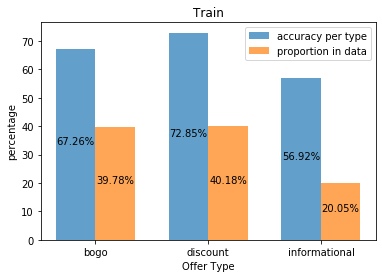

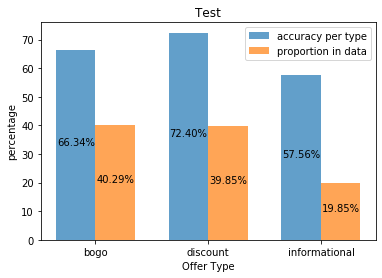

In [23]:
par=baseline_model(train_test_df,scaler=True)

analysis_error(par)

- We will calculate the proption of completed offer for each type
- the number of completed offers with respect to recieved ones

In [24]:
train_test_df['bogo_rate']=round(train_test_df.count_bogo_completed/train_test_df.count_bogo_received,3)
train_test_df['discount_rate']=round(train_test_df.count_discount_completed/train_test_df.count_discount_received,3)
train_test_df['informational_rate']=round(train_test_df.count_informational_completed/train_test_df.count_informational_received,3)

train_test_df.replace({np.nan:0},inplace=True)

train_acc 67.425
test_acc 67.13
features with zero coff
 ['first_discount_viewed', 'mean_duration_discount', 'mean_difficulty_discount', 'mean_difficulty_bogo', 'mean_duration_bogo', 'sum_reward_discount', 'mean_reward_bogo', 'median_duration_informational', 'median_duration_bogo', 'mean_duration_informational', 'last_informational_viewed']


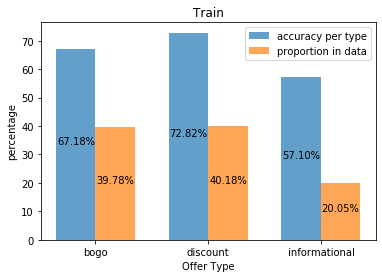

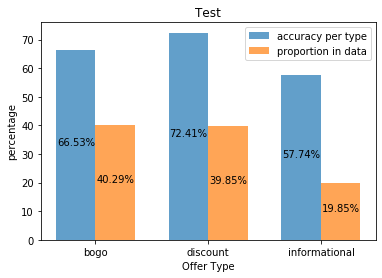

In [25]:
par=baseline_model(train_test_df)

analysis_error(par)

- We will calculate the difference time between the last event and the time when offer is send

In [26]:
for i in ['bogo','discount','informational']:
    for j in ['received','completed','viewed']:
        train_test_df['period_{}_{}'.format(i,j)] =\
        train_test_df['time']-train_test_df['last_{}_{}'.format(i,j)].replace({-1:-1000})

train_acc 67.447
test_acc 67.112
features with zero coff
 ['sum_difficulty_bogo', 'median_reward_bogo', 'period_discount_viewed', 'mean_duration_bogo', 'mean_duration_discount', 'min_duration_informational', 'min_duration_discount', 'sum_reward_bogo', 'sum_reward_discount', 'mean_difficulty_bogo', 'mean_difficulty_discount', 'median_difficulty_bogo', 'mean_reward_bogo']


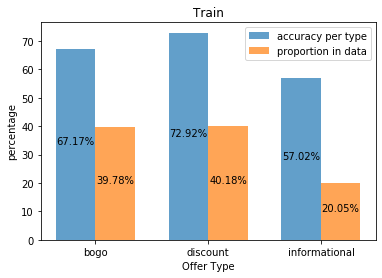

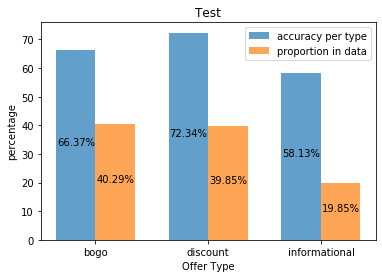

In [27]:
par=baseline_model(train_test_df)

analysis_error(par)

- for the recoeds where user didn't receive any offer before we will represent that time as -1000

In [28]:
first_last_col=train_test_df.columns[train_test_df.columns.str.contains('first|last')].to_list()
train_test_df.loc[:,first_last_col]=train_test_df[first_last_col].replace({-1:-1000})


- how often customer make a transaction
- the period from last transaction

In [29]:
train_test_df['transaction_rate']=(train_test_df.time-\
                                   train_test_df.time_first_transaction)/train_test_df.count_transaction
train_test_df['transaction_prop']=(train_test_df.time-\
                                   train_test_df.time_first_transaction)/train_test_df.sum_transaction
train_test_df['period_transaction'] = train_test_df['time']-train_test_df.time_last_transaction

In [30]:
train_test_df.replace({np.inf:10000},inplace=True)

-  we need to know the difference between reward and duration and difficulty of the recieved offer and average of previous  offers
- the difference between 'duration','reward','difficulty' of recieved offer and min,max,mean of previous offers

In [31]:
for i in ['duration','reward','difficulty']:
    for j in ['bogo','discount']:
        for k in ['mean','max','min']:
            train_test_df.loc[train_test_df.type==j,'diff_{}_{}'.format(i,k)] =\
            train_test_df.loc[train_test_df.type==j,i]-train_test_df.loc[train_test_df.type==j,'{}_{}_{}'.format(k,i,j)]

In [32]:
for k in ['mean','max','min']:
    train_test_df.loc[train_test_df.type=='informational','diff_duration_{}'.format(k)] =\
            train_test_df.loc[train_test_df.type=='informational','duration']-\
            train_test_df.loc[train_test_df.type=='informational','{}_duration_informational'.format(k)]

In [33]:
#as informational offer isn't have reward or diffiuilty so will set null values with 0
train_test_df.fillna(0,inplace=True)

train_acc 67.308
test_acc 67.01
features with zero coff
 ['last_informational_received', 'first_discount_viewed', 'first_informational_received', 'first_bogo_received', 'diff_duration_mean', 'last_bogo_received', 'last_discount_received', 'mean_duration_informational', 'last_bogo_viewed', 'last_discount_viewed', 'last_informational_viewed', 'mean_duration_discount', 'last_discount_completed', 'median_difficulty_bogo', 'mean_difficulty_discount', 'mean_difficulty_bogo', 'mean_reward_bogo', 'min_reward_discount', 'median_duration_informational', 'min_duration_discount', 'median_duration_bogo', 'mean_duration_bogo', 'time']


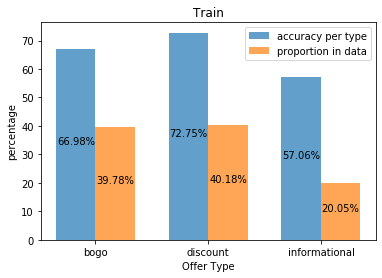

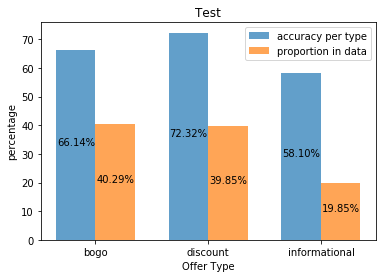

In [34]:
par=baseline_model(train_test_df)

analysis_error(par)

- rate of making offer transactions (recieve,view,complete)
as average of hours when user recieve or complete an offer

In [35]:
for i in ['bogo','discount','informational']:
    for j in ['received','completed']:
        train_test_df['{}_{}_rate'.format(i,j)] =\
        (train_test_df['time']-train_test_df['first_{}_{}'.format(i,j)])/train_test_df['count_{}_{}'.format(i,j)]

In [36]:
#I will represent inf (when user didn't receive or complete any offer before) with large number 10000
train_test_df.replace({np.inf:10000},inplace=True)

train_acc 67.342
test_acc 67.016
features with zero coff
 ['bogo_rate', 'mean_difficulty_discount', 'median_reward_bogo', 'mean_reward_bogo', 'min_reward_discount', 'diff_duration_mean', 'first_discount_received', 'first_bogo_viewed', 'first_discount_viewed', 'mean_difficulty_bogo', 'sum_duration_informational', 'last_bogo_received', 'last_discount_received', 'last_informational_received', 'last_bogo_viewed', 'last_discount_viewed', 'last_informational_viewed', 'median_difficulty_bogo', 'last_discount_completed', 'mean_duration_discount', 'mean_duration_bogo', 'min_duration_informational', 'time']


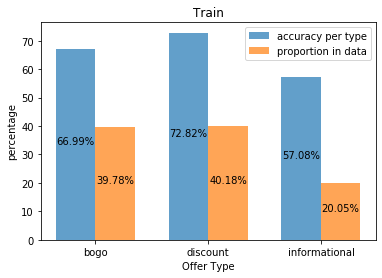

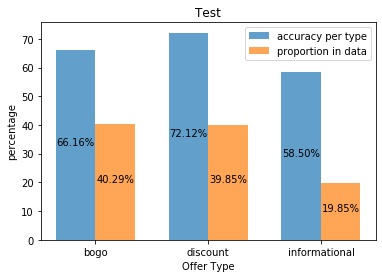

In [37]:
par=baseline_model(train_test_df)

analysis_error(par)

- numbers of uncompleted offers

In [38]:
for i in ['bogo','discount','informational']:
     train_test_df['{}_uncompleted'.format(i)] =\
            train_test_df['count_{}_received'.format(i)]-train_test_df['count_{}_completed'.format(i)]
    

train_acc 67.31
test_acc 66.961
features with zero coff
 ['last_bogo_received', 'first_discount_received', 'last_discount_viewed', 'first_discount_viewed', 'first_bogo_viewed', 'last_informational_received', 'last_informational_viewed', 'mean_difficulty_bogo', 'last_discount_completed', 'count_bogo_completed', 'diff_duration_mean', 'bogo_rate', 'count_informational_completed', 'median_difficulty_bogo', 'mean_difficulty_discount', 'sum_reward_discount', 'median_reward_bogo', 'mean_reward_bogo', 'min_reward_discount', 'min_reward_bogo', 'sum_duration_informational', 'mean_duration_discount', 'mean_duration_bogo', 'min_duration_informational', 'count_discount_completed', 'time']


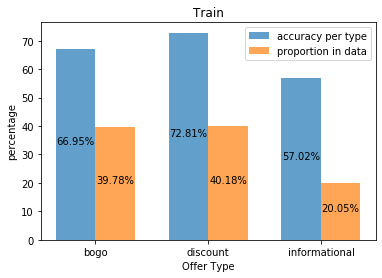

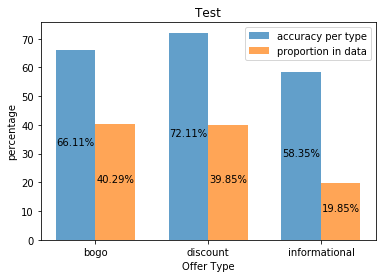

In [39]:
par=baseline_model(train_test_df)

analysis_error(par)

- rate of uncompleted offers with respect to received ones

In [40]:
for i in ['bogo','discount','informational']:
     train_test_df['{}_uncom_rec'.format(i)] =\
            train_test_df['{}_uncompleted'.format(i)]/train_test_df['count_{}_received'.format(i)]

In [41]:
train_test_df.replace({np.nan:0},inplace=True)

train_acc 67.32
test_acc 67.003
features with zero coff
 ['last_discount_received', 'last_discount_viewed', 'last_informational_received', 'first_discount_viewed', 'last_bogo_received', 'first_discount_received', 'first_bogo_viewed', 'last_informational_viewed', 'median_difficulty_bogo', 'last_discount_completed', 'count_bogo_completed', 'informational_uncom_rec', 'discount_uncom_rec', 'bogo_received_rate', 'diff_duration_mean', 'count_informational_completed', 'mean_difficulty_discount', 'mean_difficulty_bogo', 'median_reward_bogo', 'mean_reward_bogo', 'min_reward_discount', 'sum_duration_informational', 'mean_duration_discount', 'mean_duration_bogo', 'min_duration_informational', 'count_discount_completed', 'time']


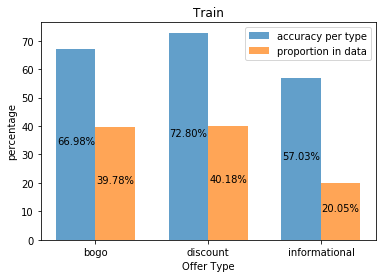

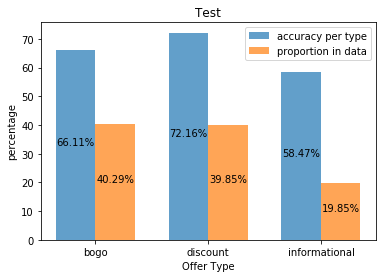

In [42]:
par=baseline_model(train_test_df)

analysis_error(par)

- ratio between mean transaction and income
- ratio between  sum transaction and income

In [43]:
for i in ['mean','sum']:
    train_test_df['tra_income_{}'.format(i)] =\
            train_test_df['{}_transaction'.format(i)]/train_test_df['income']

train_acc 67.876
test_acc 67.557
features with zero coff
 ['period_bogo_completed', 'discount_uncom_rec', 'last_discount_viewed', 'last_informational_received', 'last_discount_received', 'last_bogo_received', 'last_informational_viewed', 'first_bogo_viewed', 'first_discount_viewed', 'informational_uncom_rec', 'first_informational_received', 'count_discount_completed', 'last_discount_completed', 'sum_duration_bogo', 'mean_difficulty_discount', 'median_reward_bogo', 'mean_reward_bogo', 'min_reward_discount', 'sum_duration_informational', 'median_difficulty_bogo', 'mean_duration_discount', 'diff_duration_mean', 'mean_duration_bogo', 'min_duration_discount', 'median_transaction', 'mean_difficulty_bogo', 'count_bogo_completed', 'count_informational_completed', 'time']


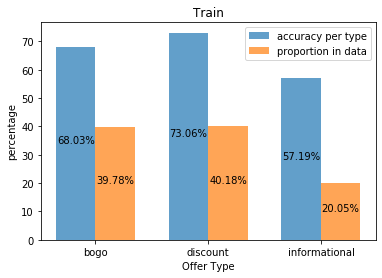

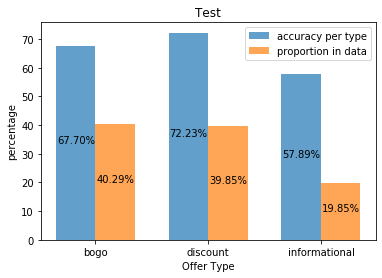

In [44]:
par=baseline_model(train_test_df)

analysis_error(par)

train_acc 67.876
precision 0.679
recall 0.679
f1 0.679

test_acc 67.557
precision 0.676
recall 0.676
f1 0.676



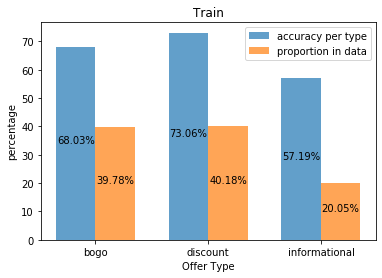

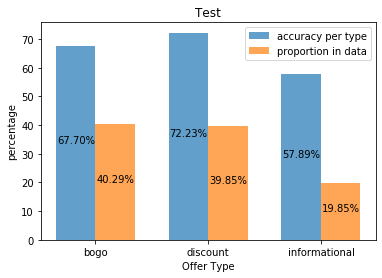

In [45]:
features_logitic,logistic_result=baseline_model(train_test_df,features_coffecients=True,f1=True)
analysis_error(logistic_result)

In [46]:
features_df=features_logitic.copy()

In [47]:
#coffecient of featuers
features_df

difficulty                        1.424353
type_bogo                         0.975199
transaction_prop                  0.900972
reward                            0.849770
type_informational                0.804010
tra_income_mean                   0.750131
mean_transaction                  0.548293
max_transaction                   0.446178
transaction_rate                  0.426926
sum_transaction                   0.397662
first_informational_completed     0.386575
informational_received_rate       0.350411
sum_difficulty_discount           0.348040
year                              0.330070
period_transaction                0.290807
sum_duration_discount             0.268999
last_informational_completed      0.257117
count_bogo_viewed                 0.251507
gender_M                          0.249540
duration                          0.245672
count_discount_received           0.240740
max_reward_discount               0.209766
discount_received_rate            0.208254
count_disco

In [48]:
#grap all features relates to first time of events for each offer
first_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+received$')].to_list()
first_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+viewed$')].to_list()
first_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^first.+completed$')].to_list()

#grap all features relates to first time of events for each offer
last_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+received$')].to_list()
last_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+viewed$')].to_list()
last_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^last.+completed$')].to_list()

# #grap all features relates to number of events for each offer
# count_offer_received = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+received$')].to_list()
# count_offer_viewed = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+viewed$')].to_list()
# count_offer_completed = train_test_df.columns[train_test_df.columns.str.contains(r'^count.+completed$')].to_list()

In [49]:
# offers_properties=['{}_{}_{}'.format(i,j,k) for i in ['max','min',
#                                     'median','sum']for j in ['duration','reward','difficulty'] for k in ['bogo','discount'] ]
# list3=['{}_duration_informational'.format(i) for i in ['max','min','median','sum']  ]

# offers_properties.extend(list3)

- we will see the coff of features we graped

train_acc 72.784
test_acc 70.859


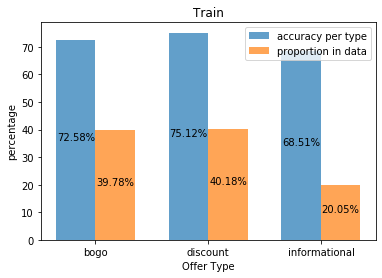

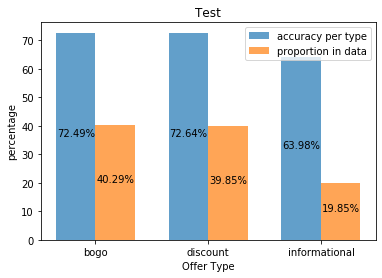

In [54]:
par=random_forest(train_test_df,max_features='auto')
analysis_error(par)

train_acc 74.935
test_acc 72.687


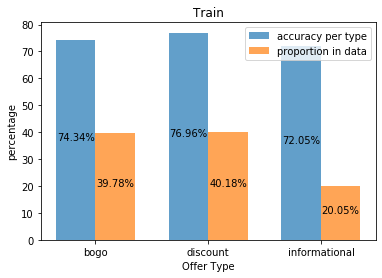

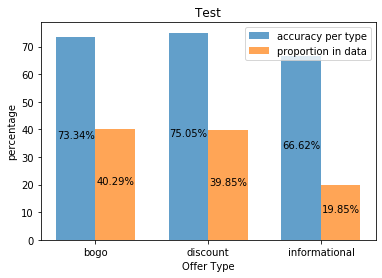

In [55]:
par=random_forest(train_test_df,max_features=.75)
analysis_error(par)

- we can see a big difference when set max feauters to 75% 

## features selection

train_acc 74.953
test_acc 72.723


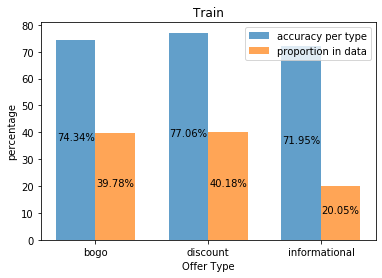

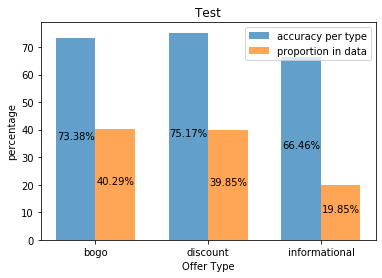

In [56]:
#start with droping all first features as it don't as engouh value
temp=train_test_df.drop(columns=first_offer_completed+first_offer_received+first_offer_viewed)

features_imp,par=random_forest(temp,max_features=.75,features=True)
analysis_error(par)

In [57]:
#we will exctract from first features all features with coeff < .01
temp=features_df[first_offer_completed+first_offer_received+first_offer_viewed]
col=temp[temp<.01].index.to_list()

train_acc 74.985
test_acc 72.717


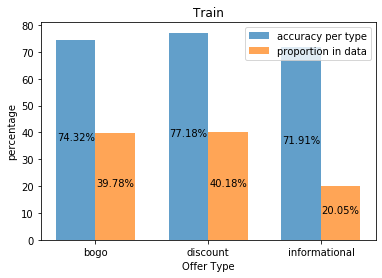

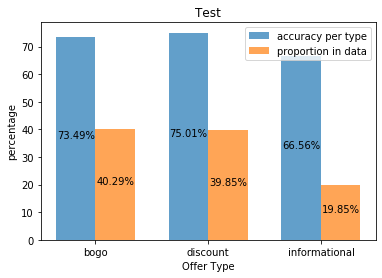

In [58]:
#start with droping all first features as it don't as engouh value
temp=train_test_df.drop(columns=col)

features_imp,par=random_forest(temp,max_features=.75,features=True,n_estimators=100)
analysis_error(par)

In [59]:
features_imp

tra_income_mean                   0.202967
year                              0.108830
duration                          0.104258
reward                            0.100057
difficulty                        0.091567
median_transaction                0.052675
income                            0.046608
transaction_rate                  0.021550
max_transaction                   0.019165
time_last_transaction             0.018854
month                             0.017401
mean_transaction                  0.015363
min_transaction                   0.014789
time                              0.013315
count_transaction                 0.012760
type_informational                0.012751
age                               0.011967
tra_income_sum                    0.008849
diff_difficulty_min               0.008206
type_bogo                         0.008021
last_transaction                  0.007478
diff_duration_min                 0.007439
transaction_prop                  0.006688
diff_durati

In [60]:
col_drop=features_imp[features_imp<.001].index.to_list()

train_acc 76.626
test_acc 72.952


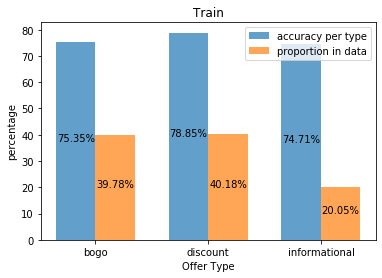

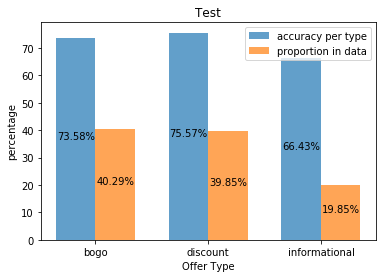

In [61]:
#start with droping all first features as it don't as engouh value
temp=train_test_df.drop(columns=col_drop)

features_imp,par=random_forest(temp,max_features=.75,features=True,n_estimators=100,max_depth=9)
analysis_error(par)

- drop the least important features wasn't helpful as well as number of n_estimators
- so we will remain on these paramters unchanged

train_acc 76.678
test_acc 73.09


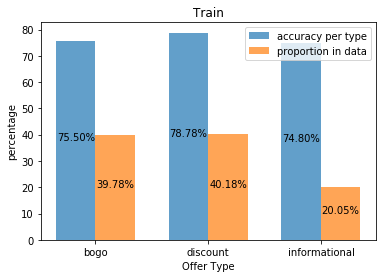

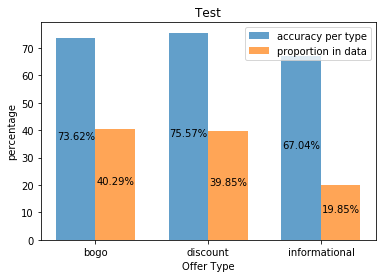

In [62]:
features_imp,par=random_forest(train_test_df,max_features=.75,features=True,n_estimators=100,max_depth=9)
analysis_error(par)

train_acc 76.678
test_acc 73.09


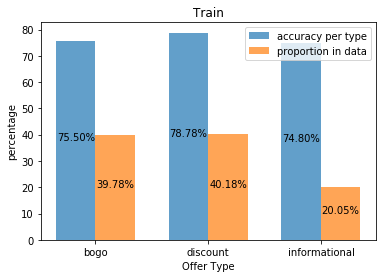

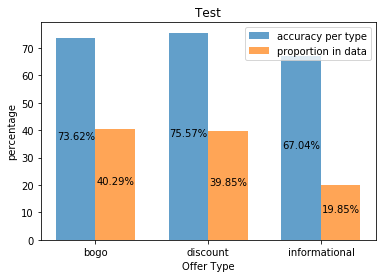

In [63]:
features_imp,par=random_forest(train_test_df,max_features=.75,features=True,n_estimators=100,
                               max_depth=9)
analysis_error(par)

0.6
train_acc 76.483
test_acc 72.946


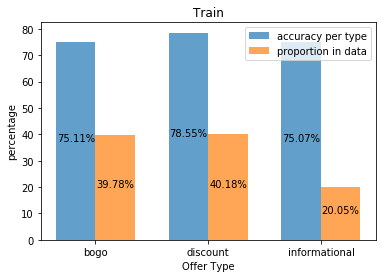

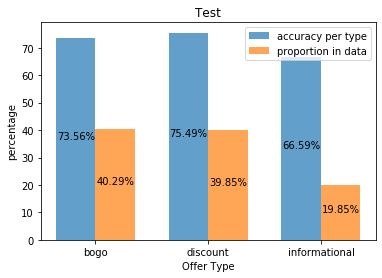

0.7
train_acc 76.553
test_acc 73.006


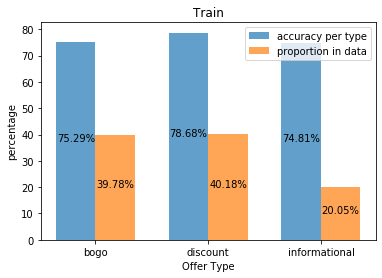

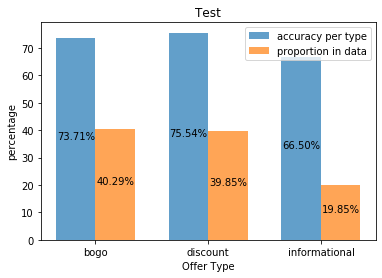

0.8
train_acc 76.599
test_acc 72.916


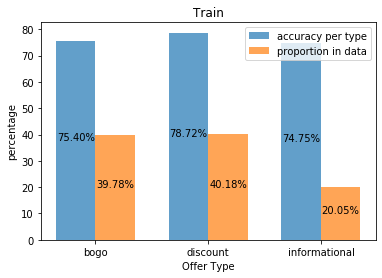

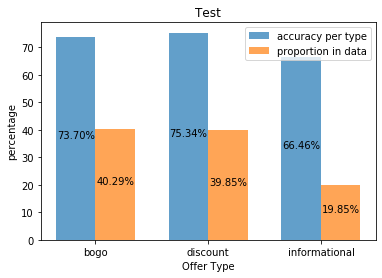

0.9
train_acc 76.656
test_acc 72.778


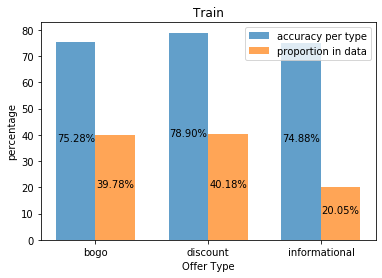

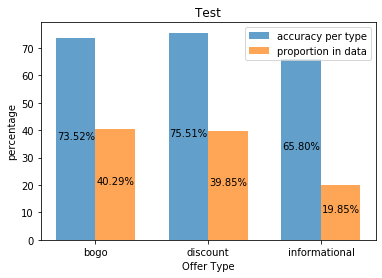

None
train_acc 76.608
test_acc 72.735


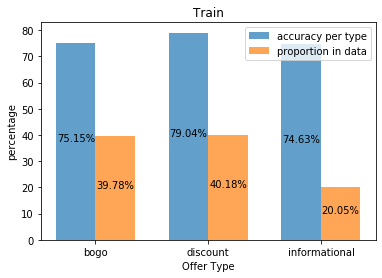

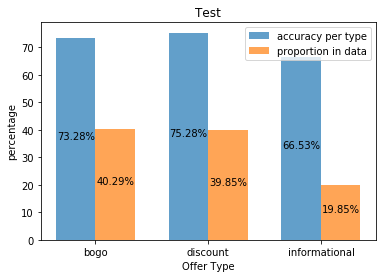

In [64]:
for i in [.6,.7,.8,.9,None]:
    print(i)
    features_imp,par=random_forest(train_test_df,max_features=i,features=True,n_estimators=100,
                                max_depth=9)
    analysis_error(par)
    

- the best max features will be .75

train_acc 76.678
precision 0.767
recall 0.767
f1 0.767

test_acc 73.09
precision 0.731
recall 0.731
f1 0.731



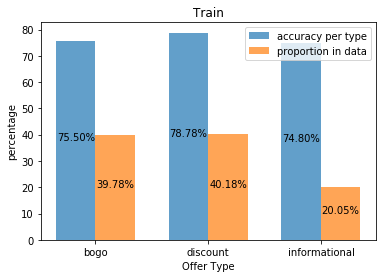

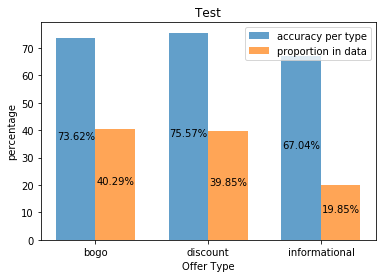

In [65]:
#final model
features_rforest,rforest_result=random_forest(train_test_df,max_features=.75,features=True,n_estimators=100,
                               max_depth=9,f1=True)
analysis_error(rforest_result)

In [66]:
#we will exctract from first features all features with coeff < .01
col=features_df[features_df<.01].index.to_list()

train_acc 67.876
test_acc 67.364


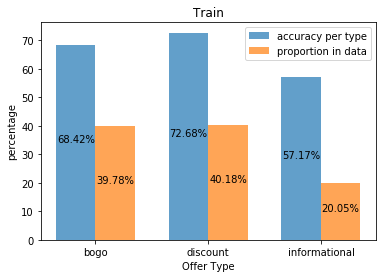

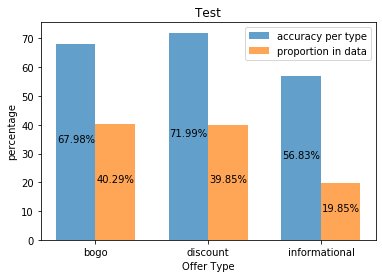

In [67]:
par=svm(train_test_df.drop(columns=col),tol=.5,max_iter=-1)
analysis_error(par)

train_acc 70.232
test_acc 69.109


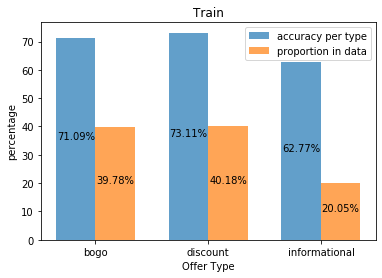

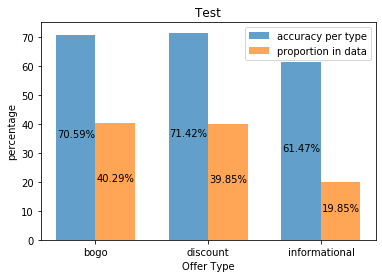

In [68]:
par=svm(train_test_df.drop(columns=col),tol=.5,max_iter=-1,degree=2)
analysis_error(par)

train_acc 69.562
test_acc 68.447


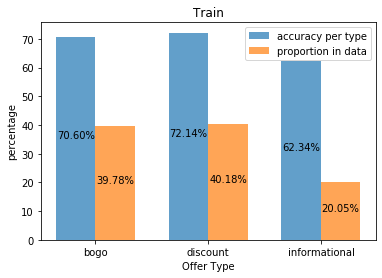

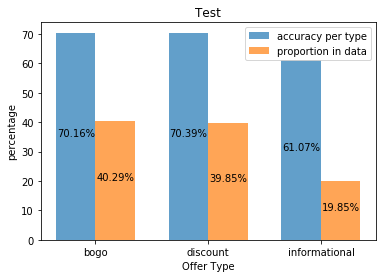

In [69]:
par=svm(train_test_df,tol=.5,max_iter=-1,degree=2)
analysis_error(par)

train_acc 72.509
precision 0.725
recall 0.725
f1 0.725

test_acc 70.684
precision 0.707
recall 0.707
f1 0.707



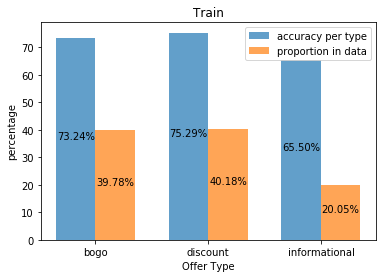

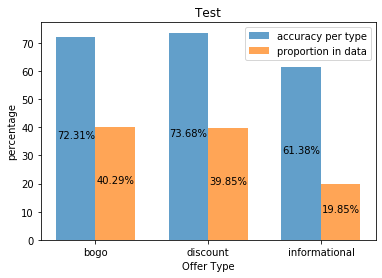

In [70]:
#final
svm_result=svm(train_test_df,tol=.1,max_iter=-1,kernel='rbf',C=1,f1=True)
analysis_error(svm_result)

train_acc 77.572
test_acc 73.217


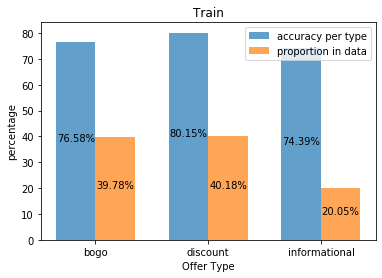

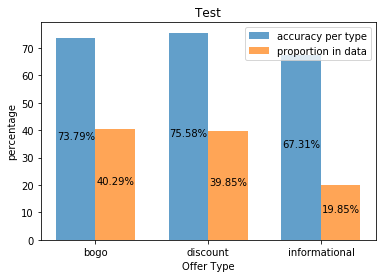

In [71]:
grad=gradient(train_test_df,max_depth=8)
analysis_error(grad)

train_acc 74.875
precision 0.749
recall 0.749
f1 0.749

test_acc 73.277
precision 0.733
recall 0.733
f1 0.733



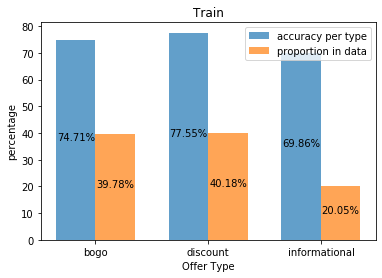

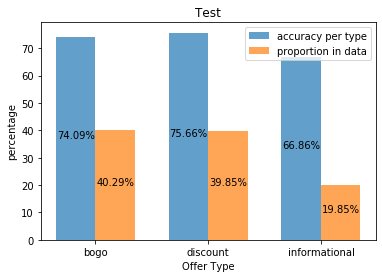

In [72]:
grad=gradient(train_test_df,max_depth=5,n_estimators=50,init=None,f1=True)
analysis_error(grad)

train_acc 81.039
precision 0.810
recall 0.810
f1 0.810

test_acc 73.782
precision 0.738
recall 0.738
f1 0.738



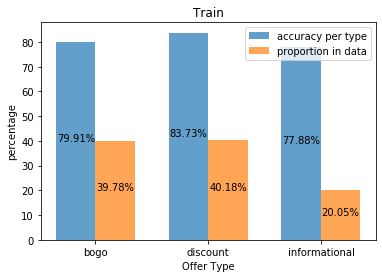

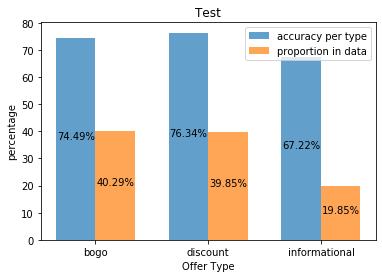

In [73]:
grad=gradient(train_test_df,max_depth=8,n_estimators=50,init=None,f1=True)
analysis_error(grad)

train_acc 79.202
precision 0.792
recall 0.792
f1 0.792

test_acc 71.442
precision 0.714
recall 0.714
f1 0.714



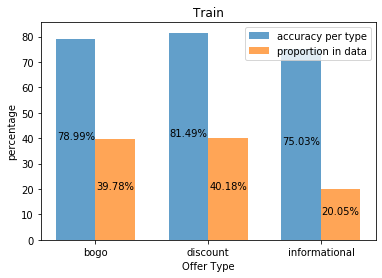

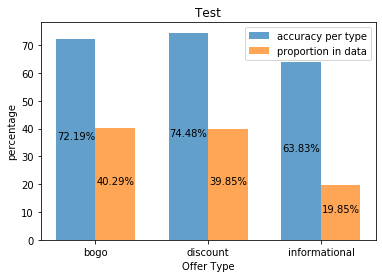

In [74]:
grad=gradient(train_test_df,max_depth=5,n_estimators=50,init=None,f1=True,learning_rate=.9)
analysis_error(grad)

train_acc 83.415
precision 0.834
recall 0.834
f1 0.834

test_acc 70.69
precision 0.707
recall 0.707
f1 0.707



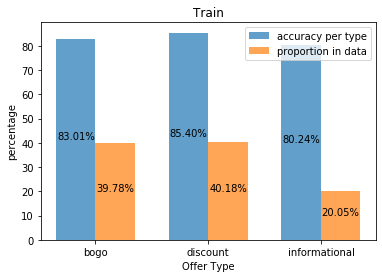

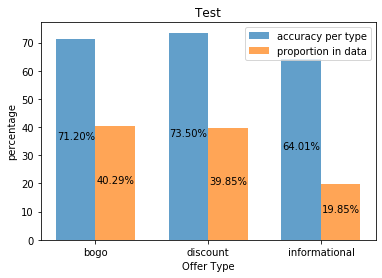

In [75]:
grad=gradient(train_test_df,max_depth=5,n_estimators=100,init=None,f1=True,learning_rate=.9)
analysis_error(grad)

train_acc 72.682
precision 0.727
recall 0.727
f1 0.727

test_acc 71.966
precision 0.720
recall 0.720
f1 0.720



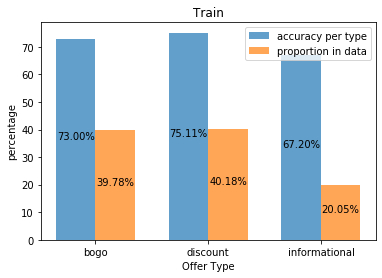

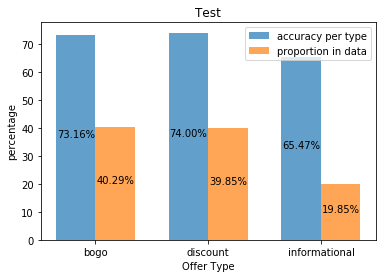

In [76]:
grad=gradient(train_test_df,max_depth=5,n_estimators=10,f1=True,learning_rate=.2)
analysis_error(grad)

train_acc 76.239
precision 0.762
recall 0.762
f1 0.762

test_acc 73.409
precision 0.734
recall 0.734
f1 0.734



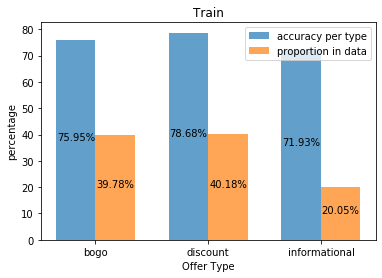

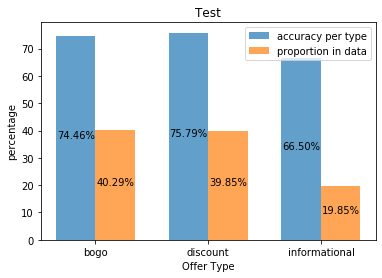

In [77]:
#final
features_gradient,gradient_result=gradient(train_test_df,max_depth=6,n_estimators=50,f1=True,features=True,init=None)
analysis_error(gradient_result)

In [78]:
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



xgb_model = xgb.XGBClassifier(objective='binary:logistic')

param_grid = {
        'max_depth': [3,5,7,8],
        'learning_rate': [ 0.1, 0.2, 0,3],
        'subsample': [ 0.8, 0.9, 1.0],
        'colsample_bytree': [ 0.7, 0.75, 0.8],
        'colsample_bylevel': [ 0.7, 0.75, 0.8],
        'min_child_weight': [.001,.01,.1],
        'gamma': [0,.001,.01,.1],
        'reg_lambda': [0.1, 1.0, 10.0],
        'n_estimators': [50,100]}

# fit_params = {'eval_metric': 'mlogloss',
#               'early_stopping_rounds': 10,
#               'eval_set': [(x_valid, y_valid)]}

rs_clf = RandomizedSearchCV(xgb_model, param_grid, n_iter=20,
                              cv=None,n_jobs=2,
                            scoring='accuracy', refit=True, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(grad['X_train'], grad['y_train'])
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Randomized search time: 701.1440229415894
Best score: 0.7371829573934837
Best params: 
colsample_bylevel: 0.7
colsample_bytree: 0.75
gamma: 0.01
learning_rate: 0.1
max_depth: 8
min_child_weight: 0.1
n_estimators: 50
reg_lambda: 10.0
subsample: 1.0


train_acc 78.667
precision 0.787
recall 0.787
f1 0.787

test_acc 73.686
precision 0.737
recall 0.737
f1 0.737



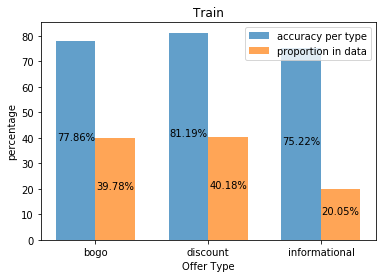

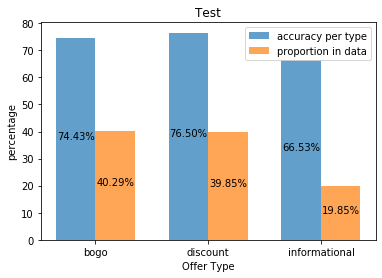

In [79]:
#final
features_xgb,xgb_result=xgb_func(train_test_df,f1=True,features=True)
analysis_error(xgb_result)

In [81]:
#combine all model ouptut in dictionary
stack_train={}
stack_test={}
for model,name in zip([logistic_result,rforest_result,gradient_result,xgb_result,svm_result],
                      ['logistic','rforest','gradient','xgb','svm']):
    print(name)
    if name == 'svm':
        stack_train['{}_train'.format(name)]= model['model'].predict(model['scaler'].transform(model['X_train']))
        stack_test['{}_test'.format(name)]  = model['model'].predict(model['scaler'].transform(model['X_test'])) 
        print(name)
    elif name == 'logistic':
        stack_train['{}_train'.format(name)]= model['model'].predict_proba(model['scaler'].transform(model['X_train']))[:,1]
        stack_test['{}_test'.format(name)]  = model['model'].predict_proba(model['scaler'].transform(model['X_test']))[:,1]
        
    else:
        stack_train['{}_train'.format(name)]= model['model'].predict_proba(model['X_train'])[:,1]
        stack_test['{}_test'.format(name)]  = model['model'].predict_proba(model['X_test'])[:,1]
    

logistic
rforest
gradient
xgb
svm
svm


In [82]:
stack_train_df=pd.DataFrame(stack_train)
stack_test_df=pd.DataFrame(stack_test)
stack_train_df.head()

,logistic_train,rforest_train,gradient_train,xgb_train,svm_train
0,0.351929,0.431840,0.518438,0.462488,0.0
1,0.303356,0.183015,0.192708,0.218995,0.0
2,0.718914,0.735711,0.786495,0.821642,1.0
3,0.760404,0.725653,0.767371,0.785522,1.0
4,0.548221,0.333112,0.386247,0.327354,0.0


In [83]:
stack_train_df['sum']=stack_train_df.sum(axis=1)
stack_test_df['sum']=stack_test_df.sum(axis=1)

In [84]:
random=RandomForestClassifier(max_depth=7, random_state=0,n_estimators=50,max_features=.75)

_=model_learning(random,stack_train_df.values,stack_test_df.values,
                   logistic_result['y_train'],logistic_result['y_test'],f1=True)

train_acc 80.63
precision 0.806
recall 0.806
f1 0.806

test_acc 72.832
precision 0.728
recall 0.728
f1 0.728



- stack model couldn't achieve accuracy greater than xgboost model

In [86]:
df=pd.DataFrame(xgb_result['X_test'])
df['y']=xgb_result['y_test']

accur=[]
for i in range(10000):
    bootsamp = df.sample(df.shape[0], replace = True)
    y_pred=xgb_result['model'].predict(bootsamp.iloc[:,:-1].values)
    accur.append(accuracy_score(bootsamp.iloc[:,-1].values, y_pred))
    


- null hypothesis **accuracy** <= **73** 
- alternative hypothesis **accuracy** >**73**

In [113]:
null_vales = np.random.normal(np.mean(accur), np.std(accur), 10000)

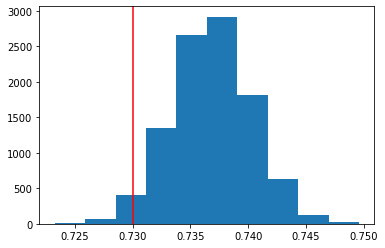

In [114]:
plt.hist(null_vales);
plt.axvline(.73 , c= 'r')
plt.show();

In [122]:
p_value=(np.asarray(accur) <.73 ).mean()
p_value

0.0224

- as p_value is less than .05 we can reject the null